In [2]:
import matplotlib.pyplot as plt
import os, re
import pandas as pd

from datetime import datetime as dt
import cPickle as pickle
import re #Regex
%matplotlib inline

# 1. Evaluating Crawling Indicator

In [3]:
%time DATACrawl = pickle.load( open( "v1.4\DATA_ANALSISIS_crawl.p", "rb" ) )
crawlIndicator = pd.DataFrame([DATACrawl.crawlMem,DATACrawl.crawlTime]).transpose()
crawlIndicator.describe()

Wall time: 3.02 s


,crawlMem,crawlTime
count,13404.000000,13404.000000
mean,3271.140555,0.430880
std,709.678721,0.732218
min,2080.000000,0.000000
25%,2808.000000,0.132600
50%,2808.000000,0.154200
75%,4072.000000,0.514300
max,6832.000000,21.701800


In [4]:
DATA_ANALSISIS_crawl    = DATACrawl[DATACrawl.flag.isin([-1, 1])]
DATA_ANALSISIS_crawlPos = DATA_ANALSISIS_crawl[DATA_ANALSISIS_crawl.flag == 1]
DATA_ANALSISIS_crawlNeg = DATA_ANALSISIS_crawl[DATA_ANALSISIS_crawl.flag == -1]
crawlAnalysis = pd.DataFrame([DATA_ANALSISIS_crawlPos.crawlMem,DATA_ANALSISIS_crawlPos.crawlTime,
                              DATA_ANALSISIS_crawlNeg.crawlMem,DATA_ANALSISIS_crawlNeg.crawlTime]).transpose()
crawlAnalysis.columns = ['Memory Positif','Time Positif','Memory Negatif','Time Negatif']
print 'Memory Positif : ',sum(DATA_ANALSISIS_crawlPos.crawlMem), 'Byte'
print 'Memory Negatif : ',sum(DATA_ANALSISIS_crawlNeg.crawlMem), 'Byte'
print 'Time Positif   : ',sum(DATA_ANALSISIS_crawlPos.crawlTime), 'Detik'
print 'Time Negatif   : ',sum(DATA_ANALSISIS_crawlNeg.crawlTime),'Detik'
crawlAnalysis.describe()

Memory Pos :  348976.0 Byte
Memory Neg :  1135544.0 Byte
Time Pos :  21.1329 Detik
Time Neg :  81.9429 Detik


,Memory Pos,Time Pos,Memory Neg,Time Neg
count,101.000000,101.000000,406.000000,406.000000
mean,3455.207921,0.209237,2796.906404,0.201830
std,785.354344,0.247792,503.250909,0.309477
min,2368.000000,0.039900,2368.000000,0.031600
25%,2520.000000,0.124600,2520.000000,0.074825
50%,3920.000000,0.141900,2520.000000,0.111750
75%,4072.000000,0.158200,2808.000000,0.150275
max,6832.000000,1.492700,4104.000000,1.957100


# 2.Evaluating the Classifier v1.5 vs v1.6


## 2.1 Load from the 'Pickled' dump

In [5]:
DATAStem = pd.DataFrame()
DATAPost = pd.DataFrame()

In [6]:
#Load from Stemmed Text
%time DATAStem['Judul'] = pickle.load( open( "v1.5\DATA_JUDULStem.p", "rb" ) )
%time DATAStem['Short'] = pickle.load( open( "v1.5\DATA_SHORTStem.p", "rb" ) )
%time DATAStem['Long']  = pickle.load( open( "v1.5\DATA_LONGStem.p", "rb" ) )

#Load from PosTagged Text
%time DATAPost['Judul'] = pickle.load( open( "v1.6\DATA_JUDULpostag.p", "rb" ) )
%time DATAPost['Short'] = pickle.load( open( "v1.6\DATA_SHORTpostag.p", "rb" ) )
%time DATAPost['Long']  = pickle.load( open( "v1.6\DATA_LONGpostag.p", "rb" ) )

%time DATA_TARGET = pickle.load( open( "v1.4\DATA_TARGET.p", "rb" ) )

# DATA_TARGET = DATA_TARGET.sort_index()
# DATAStem = DATAStem.sort_index()
# DATAPost = DATAPost.sort_index()

DATA_TARGET = DATA_TARGET.reset_index(drop=True)
DATAStem = DATAStem.reset_index(drop=True)
DATAPost = DATAPost.reset_index(drop=True)

Wall time: 176 ms
Wall time: 4 ms
Wall time: 98 ms
Wall time: 32 ms
Wall time: 54 ms
Wall time: 109 ms
Wall time: 75 ms


In [42]:
DATAPost.head(2)

,Judul,Short,Long
0,keuntungan mengambil kpr lajang,lajang kebutuhan mendesak,merdeka com memiliki rumah menjadi impian oran...
1,ngototnya pemerintah takkan minta maaf soal ka...,tidak terpikir meminta maaf,merdeka com meski didesak pihak pemerintah ke...


In [43]:
DATAStem.head(2)

,Judul,Short,Long
0,6 untung ambil kpr saat masih lajang,saat masih lajang memang butuh tak terlalu desak,merdeka com - milik rumah jadi impi semua oran...
1,ngototnya perintah tak minta maaf soal kasus 65,tidak pernah kita pikir untuk minta maaf,merdeka com - meski sudah desak jumlah pihak p...


## 2. Evaluate

In [7]:
#Stopwords data source : https://www.illc.uva.nl/Research/Publications/Reports/MoL-2003-02.text.pdf
stopword_html = open("id.stopwords.01.01.2016.txt",'r').read()
stopwords     = stopword_html.split("\n")

In [38]:
from sklearn import cross_validation
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score
from sklearn.metrics import precision_score, recall_score, classification_report, roc_auc_score,roc_curve
import datetime

def skorStratCV(clf,X,y,nfolds=10):
    skf = cross_validation.StratifiedKFold(y, n_folds=nfolds)
    metrics = []
    
    trainTime,testTime = [],[]
    precis,recals,f1s,accs,rocs = [],[],[],[],[]
    
    for train_index, test_index in skf:
        X_train,y_train = X[train_index],y[train_index]
        X_test,y_test   = X[test_index],y[test_index]
        
        #training time
        start = dt.now()
        clf.fit(X_train, y_train)
        end = dt.now()
        trainTime.append((end-start).microseconds)
        
        #testing time
        start = dt.now()
        yhat = clf.predict(X_test)
        end = dt.now()
        testTime.append((end-start).microseconds)
        
        #score
        precis.append(precision_score(y_test, yhat, average='binary'))
        recals.append(recall_score(y_test, yhat, average='binary'))
        f1s.append(f1_score(y_test, yhat, average='binary'))
        accs.append(accuracy_score(y_test, yhat))
        rocs.append(roc_auc_score(y_test,clf.predict_proba(X_test)[:,1]))
    
    def ave(lis):
        return sum(lis)/len(lis)
    
    metrics.append(ave(trainTime))
    metrics.append(ave(testTime))
    metrics.append(ave(precis))
    metrics.append(ave(recals))
    metrics.append(ave(f1s))
    metrics.append(ave(accs))
    metrics.append(ave(rocs))
    return metrics

In [37]:
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline

mnb = MultinomialNB(alpha=0.1)
#knn = KNeighborsClassifier()
svc = SVC(class_weight='balanced',probability=True,kernel='linear',cache_size=600)
#tre = DecisionTreeClassifier(class_weight='balanced')

vect = TfidfVectorizer(stop_words=stopwords,decode_error='ignore')

models = [{'name' : 'MNB', 'pipe' : Pipeline([('vect', vect),('clf', mnb)])},
          #{'name' : 'KNN', 'pipe' : Pipeline([('vect', vect),('clf', knn)])},
          {'name' : 'SVM', 'pipe' : Pipeline([('vect', vect),('clf', svc)])},
          #{'name' : 'TREE', 'pipe' : Pipeline([('vect', vect),('clf', tre)])}
         ]

In [39]:
X = []
metric = []
X.append({'name':'Judul','Prep':'Stem','Data':DATAStem['Judul']})
X.append({'name':'Judul','Prep':'Post','Data':DATAPost['Judul']})

X.append({'name':'Short','Prep':'Stem','Data':DATAStem['Short']})
X.append({'name':'Short','Prep':'Post','Data':DATAPost['Short']})

X.append({'name':'Long','Prep':'Stem','Data':DATAStem['Long']})
X.append({'name':'Long','Prep':'Post','Data':DATAPost['Long']})

y  = DATA_TARGET
for xi in X:
    x = xi['Data']
    for mod in models:
        metric.append({'name':xi['name']+' '+xi['Prep']+' '+mod['name'],
                       'metrics':skorStratCV(mod['pipe'],x,y)})

In [40]:
from ipy_table import *
metrics_table = []
tables = []
columns = (['id', 'nama','training time', 'testing time','p_1',
            'r_1','F1 score','accuracy','ROC'])
tables.append(columns)

i = 0

for me in metric:
    i += 1
    
    metr = []
    metr.append(i)
    metr.append(me['name'])
    for m in me['metrics']:
        metr.append(m)

    tables.append(metr)
    metrics_table.append(metr)
    #print metric
    
make_table(tables)

# styling
apply_theme('basic_both')
set_column_style(7, align='center')

id,nama,training time,testing time,p_1,r_1,F1 score,accuracy,ROC
1,Judul Stem MNB,14100,1800,0.7653,0.6464,0.6681,0.8703,0.8960
2,Judul Stem SVM,96200,4200,0.6940,0.6364,0.6365,0.8516,0.8956
3,Judul Post MNB,11700,1600,0.7695,0.6573,0.6738,0.8682,0.8837
4,Judul Post SVM,87500,2800,0.7132,0.6173,0.6263,0.8516,0.8791
5,Short Stem MNB,13900,2000,0.7689,0.7464,0.7424,0.8931,0.8983
6,Short Stem SVM,97000,3300,0.8336,0.7355,0.7641,0.9031,0.8980
7,Short Post MNB,11800,1600,0.7010,0.7673,0.7094,0.8725,0.8982
8,Short Post SVM,96800,2700,0.8137,0.7173,0.7324,0.8909,0.8873
9,Long Stem MNB,146400,16000,0.9026,0.6845,0.7493,0.9136,0.9392
10,Long Stem SVM,93000,31300,0.8474,0.7436,0.7688,0.9136,0.9482


In [44]:
evals = pd.DataFrame(metrics_table,columns=columns)
evals['Vars'] = [i.split()[0] for i in evals['nama']]
evals['Prep'] = [i.split()[1] for i in evals['nama']]
evals['Algs'] = [i.split()[2] for i in evals['nama']]
evals.drop('nama',axis=1,inplace=True)
evals.drop('id',axis=1,inplace=True)

In [45]:
splitter = ['Judul','Short','Long']
eval_teks = pd.DataFrame([evals[evals.Vars == i].mean() for i in splitter]).transpose()
eval_teks.set_axis(1,splitter)
eval_teks

,Judul,Short,Long
training time,52375.000000,54875.000000,140750.000000
testing time,2600.000000,2400.000000,22775.000000
p_1,0.735505,0.779305,0.881181
r_1,0.639318,0.741591,0.712045
F1 score,0.651181,0.737075,0.759212
accuracy,0.860446,0.889878,0.914606
ROC,0.888603,0.895460,0.938808


In [46]:
splitter = ['Post','Stem']
eval_prep = pd.DataFrame([evals[evals.Prep == i].mean() for i in splitter]).transpose()
eval_prep.set_axis(1,splitter)
eval_prep

,Post,Stem
training time,88566.666667,76766.666667
testing time,8750.000000,9766.666667
p_1,0.795341,0.801987
r_1,0.696515,0.698788
F1 score,0.710116,0.721529
accuracy,0.885765,0.890855
ROC,0.902711,0.912536


In [49]:
splitter = ['MNB','SVM']
eval_teks = pd.DataFrame([evals[evals.Algs == i].mean() for i in splitter]).transpose()
eval_teks.set_axis(1,splitter)
eval_teks

,MNB,SVM
training time,54433.333333,110900.000000
testing time,6100.000000,12416.666667
p_1,0.805834,0.791494
r_1,0.702727,0.692576
F1 score,0.719350,0.712295
accuracy,0.889904,0.886716
ROC,0.907466,0.907780


In [31]:
mnb

MultinomialNB(alpha=0.1, class_prior=None, fit_prior=True)

In [50]:
#knn
# knn_params = {'n_neighbors': range(1,21), 'weights': ['uniform', 'distance'], 'algorithm': ['ball_tree', 'kd_tree'],
#               'leaf_size': [15, 30, 50, 100], 'p': [1,2]}

In [33]:
svc
# lsvm_params = {'loss':['hinge', 'squared_hinge'],'class_weight':['balanced']}

SVC(C=1.0, cache_size=600, class_weight='balanced', coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [51]:
#tre
# tree_param = {"criterion": ["gini", "entropy"],"class_weight" : ['balanced']}

In [58]:
xplot = [[],[]]
yplot = evals.Vars.values + evals.Prep.values
xplot[0] = evals[evals.Algs == 'MNB']['F1 score']
#xplot[1] = evals[evals.Algs == 'KNN']['F1 score']
xplot[1] = evals[evals.Algs == 'SVM']['F1 score']

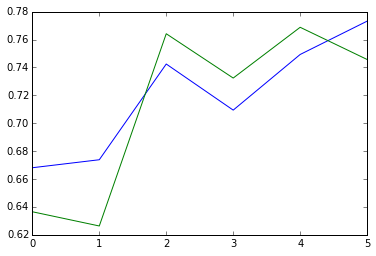

In [57]:
import matplotlib.pyplot as plt

for xi in xplot:
    plt.plot(xi)
plt.show()